### To reproduce Figure 3 results (Cora dataset):

We will reproduce the results for the Cora dataset by default, but you can choose any dataset you want by following the instructions below.

1. Open `scripts/run_figure3.sh`
2. Modify as needed:
   - `datasets` (default=Cora)
   - `experiment_name` (Name for the experiment, will be used as directory name for logs)
   - Modify the parallel parameter (-j) to adjust the number of concurrent jobs based on your system's capabilities


3. Make the script executable:
   ```
   chmod +x scripts/run_figure3.sh
   ```

4. Run the script:
   ```
   bash scripts/run_figure3.sh
   ```

Results will be logged to wandb and saved in the `logs/{experiment_name}` directory.

### Note: To reproduce results for other datasets in Figure 3:
- Modify the `datasets` array in the script (e.g., datasets=('CiteSeer') for CiteSeer dataset)
- Change the `experiment_name` accordingly (e.g., "Figure 3 results CiteSeer")

For example, to reproduce results for CiteSeer:
1. In `scripts/run_figure3.sh`, change:
   ```
   datasets=('CiteSeer')
   experiment_name="Figure 3 results CiteSeer"
   ```
2. Run the script as described above

Note: We used GCN architecture for all datasets in Figure 3, so keep architectures=('gcn')

### Parsing the results

After running the script, the logs of the experiments are stored in the directory `logs/Figure 3 results Cora`.
The code below parses these results to compute the average AUC for the Gradient and Inter-Reps attacks across multiple seeds over training epochs.
It extracts the AUC values for these two attack methods at each epoch to show their evolution during training.

The code also renames some attack methods to match the names used in the paper:
- 'gradients' is used for the Gradient attack
- 'forward_values' is renamed to 'Inter-Reps'

Don't forget to change the experiment name in the code in the next cell to parse the correct logs of the experiment for the new dataset if you're reproducing results for a different dataset.

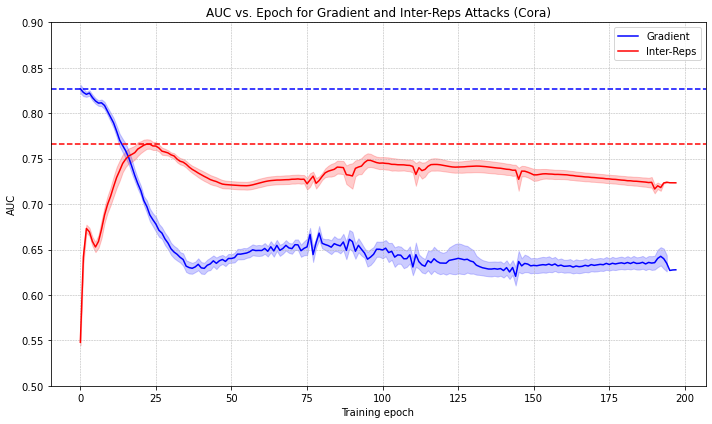

Final AUC values:
       attack       auc
0    Gradient  0.627687
1  Inter-Reps  0.723422


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

def parse_results(experiment_dir):
    results = []
    for subdir in os.listdir(experiment_dir):
        csv_path = os.path.join(experiment_dir, subdir, 'attack_results.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            
            # Filter for AUC metrics only
            auc_df = df[df['metric'].str.startswith('AUC-')].copy()
            
            # Convert 'value' column to numeric
            auc_df['value'] = auc_df['value'].apply(safe_float)
            
            # Get results for gradients and forward_values (Inter-Reps) for all epochs
            for attack in ['gradients', 'forward_values']:
                attack_results = auc_df[auc_df['metric'] == f'AUC-{attack}']
                for _, row in attack_results.iterrows():
                    attack_name = 'Inter-Reps' if attack == 'forward_values' else 'Gradient'
                    results.append({
                        'attack': attack_name,
                        'epoch': row['epoch'],
                        'auc': row['value'],
                        'seed': subdir
                    })
    
    return pd.DataFrame(results)

def plot_data(data, color, label_prefix, plot_max_auc=False):
    mean_auc = data.groupby('epoch')['auc'].mean()
    sem_auc = data.groupby('epoch')['auc'].sem()
    epochs = mean_auc.index

    plt.plot(epochs, mean_auc, label=f'{label_prefix}', color=color)
    plt.fill_between(epochs, mean_auc - sem_auc, mean_auc + sem_auc, color=color, alpha=0.2)

    if plot_max_auc:
        max_auc = mean_auc.max()
        plt.axhline(y=max_auc, color=color, linestyle='--')

# Specify the path to your experiment directory
experiment_dir = '../logs/Figure 3 results Cora'

# Parse results
results_df = parse_results(experiment_dir)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
for attack, color in [('Gradient', 'blue'), ('Inter-Reps', 'red')]:
    attack_data = results_df[results_df['attack'] == attack]
    plot_data(attack_data, color, attack, plot_max_auc=True)

ax.set_xlabel('Training epoch')
ax.set_ylabel('AUC')
ax.set_title('AUC vs. Epoch for Gradient and Inter-Reps Attacks (Cora)')
ax.set_ylim(0.5, 0.9)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Display the final AUC values
final_epoch = results_df['epoch'].max()
final_auc = results_df[results_df['epoch'] == final_epoch].groupby('attack')['auc'].mean().reset_index()
print("Final AUC values:")
print(final_auc)